In [1]:
%run env_setup.py
%matplotlib inline
import os
from importlib import reload

In [53]:
import lessdeep as ld
import numpy as np
import scipy.misc

In [3]:
#img_file = ld.utils.download_file('http://farm2.static.flickr.com/1422/987713710_f801e72921.jpg')
img_file = ld.utils.download_file('http://epmgsenior.media.clients.ellingtoncms.com/img/photos/2012/04/30/p_2_goldfinch_2_t750x550.jpg?d885fc46c41745b3b5de550c70336c1b382931d2')

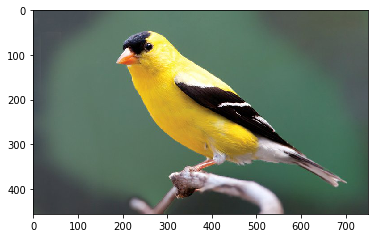

In [4]:
from matplotlib import pyplot as plt
from PIL import Image
img = np.array(Image.open(img_file), dtype=np.float32)
plt.imshow(img.astype(np.uint8))
plt.show()

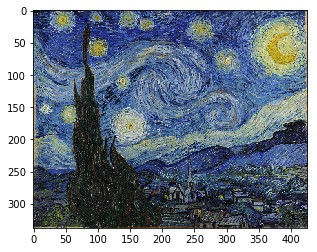

In [5]:
van_img = Image.open(ld.utils.download_file('https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'))
van_img = np.array(van_img.resize(np.divide(van_img.size, 3).astype(int)), dtype=np.float32)
plt.imshow(van_img.astype(np.uint8))
plt.show()

In [6]:
%pdb

Automatic pdb calling has been turned ON


In [7]:
from lessdeep.model.vgg16n import Vgg16N
import keras

def create_vgg_avg(image_size=None):
    vgg_avg=Vgg16N(include_top=False, image_size=image_size)
    vgg_avg_layers = []
    for l in vgg_avg.model.layers:
        if isinstance(l, keras.layers.MaxPool2D):
            vgg_avg_layers.append(keras.layers.AveragePooling2D((2, 2), strides=(2, 2)))
        else:
            vgg_avg_layers.append(l)
    vgg_avg.model = ld.utils.clone_model(vgg_avg_layers)
    vgg_avg.compile()
    
    return vgg_avg
vgg_avg = create_vgg_avg()
vgg_avg.model.summary()

Using TensorFlow backend.


58892288/58889256 [==============================] - 14s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
average_pooling2d_5 (Average (None, None, None, 64)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 128)   73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 128)   147584    
_________________________________________________________________
average_po

In [8]:
conv_idx = [i for i, l in enumerate(vgg_avg.model.layers) if isinstance(l, keras.layers.Conv2D)]

In [9]:
conv_idx

[1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17]

In [10]:
from keras.applications.imagenet_utils import preprocess_input
img_input = preprocess_input(img.copy())[None]
van_img_input = preprocess_input(van_img.copy())[None]

In [11]:
import keras.backend as K
def reverse_input(x):
    x = x.copy()
    data_format = K.image_data_format()
    if data_format == 'channels_first':
        if x.ndim == 3:
            # 'BGR'->'RGB'
            x = x[::-1, ...]
            # Zero-center by mean pixel
            x[0, :, :] += 123.68
            x[1, :, :] += 116.779
            x[2, :, :] += 103.939
        else:
            x = x[:, ::-1, ...]
            x[:, 0, :, :] += 123.68
            x[:, 1, :, :] += 116.779
            x[:, 2, :, :] += 103.939
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]
        # Zero-center by mean pixel
        x[..., 0] += 123.68
        x[..., 1] += 116.779
        x[..., 2] += 103.939
    return x

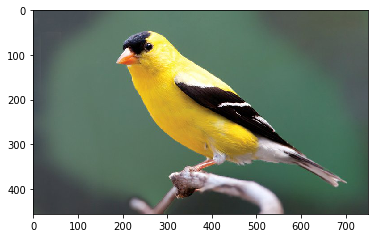

In [12]:
plt.imshow(reverse_input(img_input[0]).astype(np.uint8))
plt.show()

In [13]:
layer = vgg_avg.model.layers[conv_idx[-6]].output
layer_model = keras.Model(vgg_avg.model.input, layer)

In [14]:
tgt = K.variable(layer_model.predict(img_input))

In [15]:
loss = K.mean(keras.metrics.mse(tgt, layer))
grad = K.gradients(loss, vgg_avg.model.input)

In [16]:
class Runner(object):
    def __init__(self, f, in_shape):
        self._f, self.shape = f, in_shape
    def loss(self, x):
        loss, self._grad = self._f([x.reshape(self.shape)])
        return loss.astype(np.float64)
    def grad(self, x):
        return self._grad.astype(np.float64).flatten()
runner = Runner(K.function([vgg_avg.model.input], [loss]+grad), img_input.shape)

In [17]:
from scipy.optimize import fmin_l_bfgs_b

def learn_image(run_obj, x, niter):
    his = []
    for i in range(niter):
        x, f, d = fmin_l_bfgs_b(run_obj.loss, x.flatten(), fprime=run_obj.grad, maxiter=20)
        his.append(x.reshape(run_obj.shape).copy())
        print('Iter {0}: loss {1}'.format(i, f))
    return his

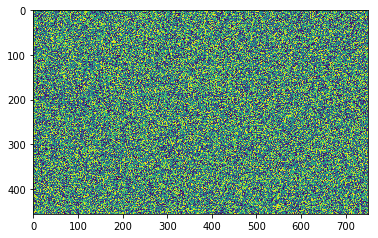

In [18]:
rand_img = np.array(np.random.uniform(-2.5, 2.5, img_input.shape).astype(np.float32)/100)
#rand_img[0]
import matplotlib
plt.imshow(rand_img[0][:,:,0])
plt.show()

In [19]:
his = learn_image(runner, rand_img, niter=20)

Iter 0: loss 2472.907958984375
Iter 1: loss 1287.681396484375
Iter 2: loss 926.0936889648438
Iter 3: loss 751.0704345703125
Iter 4: loss 637.4518432617188
Iter 5: loss 554.6659545898438
Iter 6: loss 493.82940673828125
Iter 7: loss 447.0625
Iter 8: loss 406.4462890625
Iter 9: loss 369.664306640625
Iter 10: loss 337.428955078125
Iter 11: loss 313.37060546875
Iter 12: loss 287.8504638671875
Iter 13: loss 266.76043701171875
Iter 14: loss 249.12228393554688
Iter 15: loss 232.67935180664062
Iter 16: loss 218.6234130859375
Iter 17: loss 205.4615478515625
Iter 18: loss 192.61813354492188
Iter 19: loss 181.143798828125


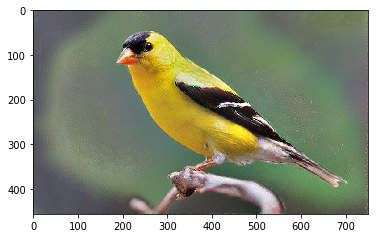

In [20]:
plt.imshow(reverse_input(his[-2][0]).clip(0, 255).astype(np.uint8))

In [21]:
from IPython.display import HTML
from matplotlib import animation, rc

In [22]:
#fig, ax = plt.subplots()
def animate(i):
    ax.imshow(reverse_input(his[-1][0]).astype(np.uint8))
#anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)
#HTML(anim.to_html5_video())

## Creating Style

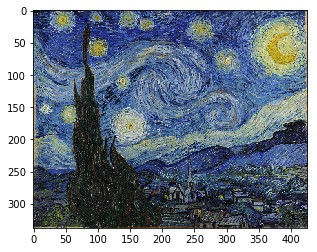

In [23]:
import scipy
plt.imshow(reverse_input(van_img_input[0]).astype(np.uint8))
plt.show()

In [24]:
style_vgg = create_vgg_avg(image_size=van_img_input[0].shape[:2])
style_layers = [style_vgg.model.layers[conv_idx[i]].output for i in range(1, len(conv_idx), 3)]
style_model = keras.Model(style_vgg.model.input, style_layers)
style_tgts = [K.variable(v) for v in style_model.predict(van_img_input)]

In [25]:
def gram_matrix(x):
    tmp = K.permute_dimensions(x, (2, 0, 1))  # convert to (depth, y, x)
    features = K.batch_flatten(tmp)  # keep depth, flatten each feature into one row
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [26]:
def style_loss(x, tgt):
    return K.mean(keras.metrics.mse(gram_matrix(x), gram_matrix(tgt)))

In [27]:
x=style_layers[0][0]
tmp = K.permute_dimensions(x, (2, 0, 1))  # convert to (depth, y, x)
tmp
features = K.batch_flatten(tmp)  # keep depth, flatten each feature into one row
tmp, features, x.get_shape()
#K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

(<tf.Tensor 'transpose:0' shape=(64, 338, 426) dtype=float32>,
 <tf.Tensor 'Reshape:0' shape=(?, ?) dtype=float32>,
 TensorShape([Dimension(338), Dimension(426), Dimension(64)]))

In [28]:
loss = sum([style_loss(l[0], t[0]) for l, t in zip(style_layers, style_tgts)])
grad = K.gradients(loss, [style_vgg.model.input])
style_runner = Runner(K.function([style_vgg.model.input], [loss]+grad), van_img_input.shape)

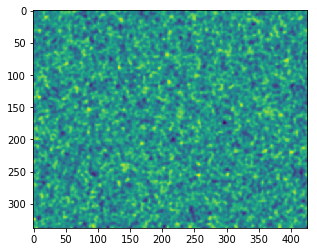

In [29]:
rand_style_img = np.array(np.random.uniform(-2.5, 2.5, van_img_input.shape).astype(np.float32)/100)
rand_style_img = scipy.ndimage.gaussian_filter(rand_style_img, [0, 2, 2, 0])
import matplotlib
plt.imshow(rand_style_img[0][:,:,0])
plt.show()

In [30]:
style_his = learn_image(style_runner, rand_style_img, 10)

Iter 0: loss 2754.145263671875
Iter 1: loss 1046.195068359375
Iter 2: loss 492.4031066894531
Iter 3: loss 207.15115356445312
Iter 4: loss 91.52357482910156
Iter 5: loss 43.71564483642578
Iter 6: loss 28.790756225585938
Iter 7: loss 20.838088989257812
Iter 8: loss 17.205026626586914
Iter 9: loss 14.709879875183105


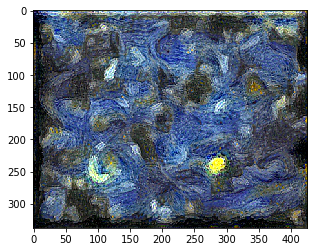

In [31]:
plt.imshow(reverse_input(style_his[-1][0]).clip(0, 255).astype(np.uint8))

## Start style

cut image size into style size

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


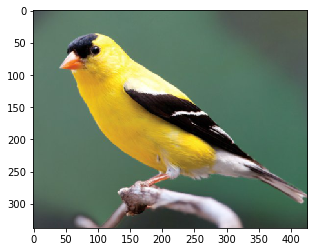

In [57]:
style_h, style_w = van_img_input.shape[1:3]
cnt_image = scipy.misc.imresize(img, 0.76)[:style_h, 100:100+style_w].astype(np.float32)
cnt_image_input = preprocess_input(cnt_image.copy())[None]
plt.imshow(reverse_input(cnt_image_input[0]).astype(np.uint8))

In [58]:
content_layer = style_layers[-1]
content_model = keras.Model(style_vgg.model.input, content_layer)
content_tgt = content_model.predict(cnt_image_input)

In [70]:
style_weight = [0.1,0.2,0.3,0.4]
loss = K.mean(keras.metrics.mse(content_tgt, content_layer))
loss = 0.2*loss + sum([style_loss(l[0], t[0])*w for l, t,w in zip(style_layers, style_tgts, style_weight)])
grad = K.gradients(loss, style_vgg.model.input)
total_runner = Runner(K.function([style_vgg.model.input], [loss]+grad), van_img_input.shape)

In [64]:
rand_style_img = np.array(np.random.uniform(-2.5, 2.5, van_img_input.shape).astype(np.float32)/100)
rand_style_img = scipy.ndimage.gaussian_filter(rand_style_img, [0, 2, 2, 0])
x = rand_style_img

In [71]:
x = cnt_image_input

In [72]:
style_his = learn_image(total_runner, x, 10)

Iter 0: loss 59.58704376220703
Iter 1: loss 22.670303344726562
Iter 2: loss 15.301172256469727
Iter 3: loss 12.529723167419434
Iter 4: loss 11.185482025146484
Iter 5: loss 10.347558975219727
Iter 6: loss 9.719520568847656
Iter 7: loss 9.136211395263672
Iter 8: loss 8.72608757019043
Iter 9: loss 8.403568267822266


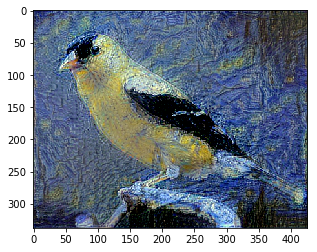

In [73]:
plt.imshow(reverse_input(style_his[-1][0]).clip(0, 255).astype(np.uint8))